# Energy Efficiency 

# Work on Y2 (Cooling Load Y2)

# Quantile Regression

In [1]:
# Cell 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve , GridSearchCV , cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (r2_score, mean_squared_error,mean_absolute_error, mean_absolute_percentage_error ,median_absolute_error, max_error)
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib
import os
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import seaborn as sns
import scipy.stats as stats
import random
np.random.seed(42)
random_seed = 42

In [2]:
#Cell 2
dataset = pd.read_excel(r"D:\Data_Science_Course\Jupyter_Data_Set\Energy Efficiency.xlsx")

data = dataset[['Relative Compactness','Surface Area','Wall Area',
                          'Roof Area','Overall Height','Glazing Area','Orientation','Glazing Area Distribution','Cooling Load (Y2)']]


data.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Orientation,Glazing Area Distribution,Cooling Load (Y2)
0,0.98,514.5,294.0,110.25,7.0,0.0,2,0,21.33
1,0.98,514.5,294.0,110.25,7.0,0.0,3,0,21.33
2,0.98,514.5,294.0,110.25,7.0,0.0,4,0,21.33
3,0.98,514.5,294.0,110.25,7.0,0.0,5,0,21.33
4,0.90,563.5,318.5,122.50,7.0,0.0,2,0,28.28


In [3]:
# Cell 3

X = data.iloc[:, :-1]
print('X shape is ', X.shape)

feature_names = data.columns[:-1]
print('X Features are: ', list(feature_names))

y = data.iloc[:, -1]
print('y shape is ', y.shape)

X shape is  (768, 8)
X Features are:  ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Glazing Area', 'Orientation', 'Glazing Area Distribution']
y shape is  (768,)


# Split dataset (Cell 4)

In [4]:
# Cell 4

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,shuffle= True, random_state=random_seed)
print("Train size : ",X_train.shape)
print("Test size : ",X_test.shape)



Train size :  (460, 8)
Test size :  (308, 8)


# Create model algorithms hyperparameter (Cell 5)

In [5]:
# Cell 5
#Model Training (Median Predictor)

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

median_model = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.5,  # Median
    random_state=random_seed
)
#neg_mean_squared_error
grid_search = GridSearchCV(
    median_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

median_model = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.5,
    random_state=random_seed,
    **best_params
)
median_model.fit(X_train, y_train)

quantile_lower = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.05,  # 5th percentile
    random_state=random_seed,
    **best_params
)

quantile_upper = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.95,  # 95th percentile
    random_state=random_seed,
    **best_params
)

quantile_lower.fit(X_train, y_train)
quantile_upper.fit(X_train, y_train)


y_pred_train = median_model.predict(X_train)
y_pred_test = median_model.predict(X_test)
y_lower_quant = quantile_lower.predict(X_test)
y_upper_quant = quantile_upper.predict(X_test)




Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


# Model evaluation (Cell 6)


Training Set Performance:
R^2: 0.9947
MSE: 0.4749
RMSE: 0.6891
MAE: 0.3079
MedAE: 0.0658
Max Error: 5.29
MAPE: 0.0108
Std Residuals: 0.6889

Test Set Performance:
R^2: 0.9840
MSE: 1.4420
RMSE: 1.2008
MAE: 0.7498
MedAE: 0.3711
Max Error: 5.72
MAPE: 0.0269
Std Residuals: 1.2002


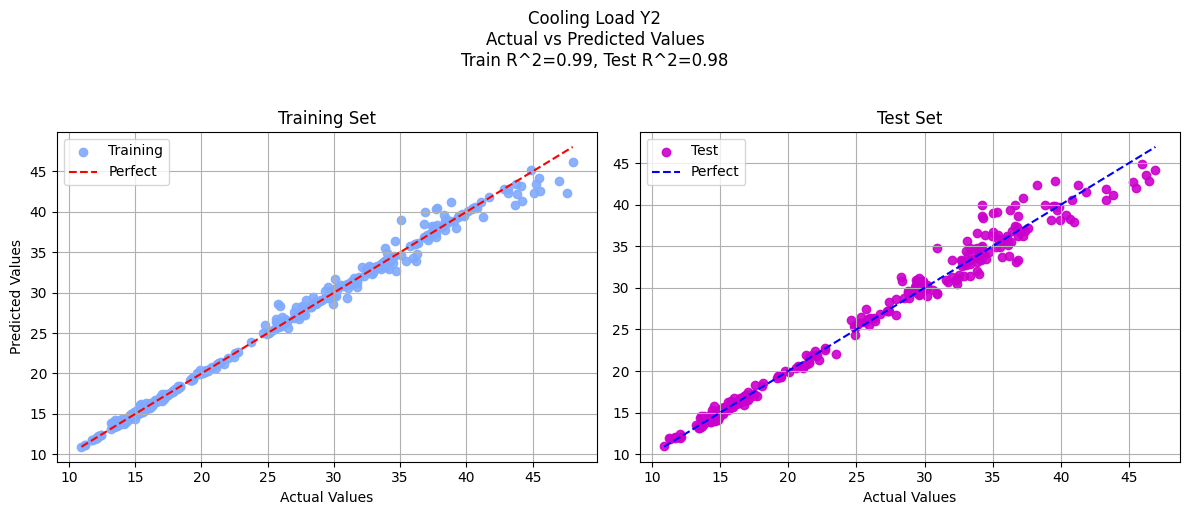


Cross-validation R^2 scores: [0.97119193 0.95408073 0.97093414 0.9858707  0.97980394]
Mean CV R^2: 0.9724 (+/- 0.0215)


In [6]:
# Cell 6
def evaluate_performance(y_true, y_pred, residuals, dataset_name):
    metrics = {
        "R^2": r2_score(y_true, y_pred),
        "MSE":mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MedAE": median_absolute_error(y_true, y_pred),
        "Max Error": max_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "Std Residuals": np.std(residuals),
    }
    
    print(f"\n{dataset_name} Set Performance:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}" if name not in ["Max Error"] 
              else f"{name}: {value:.2f}")
    
    return metrics

def median_model_residual(model, X, y):
    y_pred = model.predict(X)
    residuals = y - y_pred
    return residuals


Train_residuals = median_model_residual(median_model, X_train, y_train)
Test_residuals = median_model_residual(median_model, X_test, y_test)  

train_metrics = evaluate_performance(y_train, y_pred_train, Train_residuals, "Training")
test_metrics = evaluate_performance(y_test, y_pred_test, Test_residuals, "Test")

y_train_pred = y_pred_train.copy()
y_test_pred = y_pred_test.copy()

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    

    plt.subplot(1, 2, 1)  
    plt.scatter(y_train, y_train_pred, color='#80aaff', alpha=0.9, label='Training')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 
             '--', color='red', label='Perfect')
    plt.title('Training Set')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    

    plt.subplot(1, 2, 2)  
    plt.scatter(y_test, y_test_pred, color='#cc00cc', alpha=0.9, label='Test')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
             '--', color='blue', label='Perfect')
    plt.title('Test Set')
    plt.xlabel('Actual Values')
    plt.legend()
    plt.grid(True)
     
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

plot_predictions(y_train, y_train_pred, f"Cooling Load Y2\nActual vs Predicted Values\nTrain R^2={train_r2:.2f}, Test R^2={test_r2:.2f}")

cv_scores = cross_val_score(median_model, X_train, y_train, cv=5, scoring='r2')
print(f"\nCross-validation R^2 scores: {cv_scores}")
print(f"Mean CV R^2: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Check if there is overfit or underfit (Cell 7)


Learning Curve Analysis:


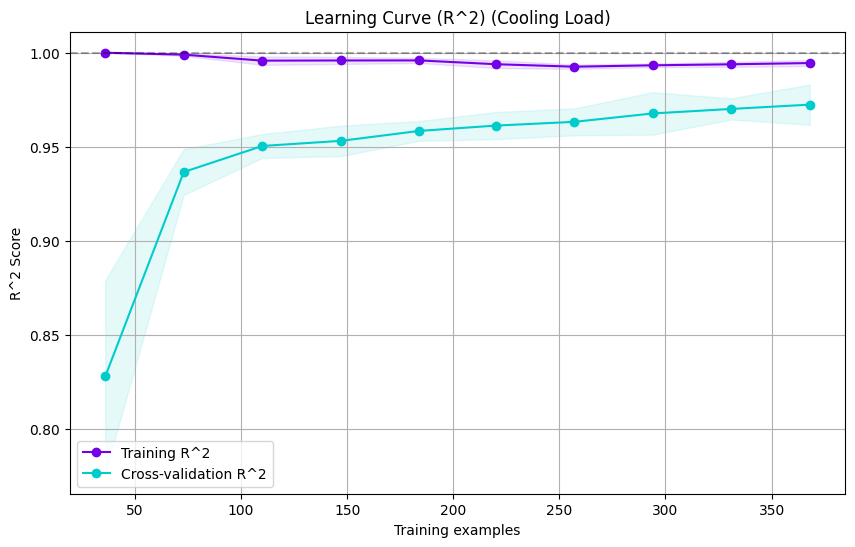


Final Training R^2: 0.9945
Final Validation R^2: 0.9724
Gap between train and validation: 0.0221
Good generalization: Small gap between training and validation


In [7]:
#Cell 7
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=train_sizes, scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#7300e6")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#00cccc")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#7300e6", label="Training R^2")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#00cccc", label="Cross-validation R^2")
    
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    plt.title("Learning Curve (R^2) (Cooling Load)")
    plt.legend(loc="best")
    plt.grid(True)
    
    plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.3)
    
    plt.show()
    
    print(f"\nFinal Training R^2: {train_scores_mean[-1]:.4f}")
    print(f"Final Validation R^2: {test_scores_mean[-1]:.4f}")
    print(f"Gap between train and validation: {train_scores_mean[-1] - test_scores_mean[-1]:.4f}")
    
    gap = train_scores_mean[-1] - test_scores_mean[-1]
    if gap > 0.1:
        print("Large gap suggests potential overfitting")
    elif gap < 0.05:
        print("Good generalization: Small gap between training and validation")
    else:
        print("Model could be underfitting")

print("\nLearning Curve Analysis:")
plot_learning_curve(median_model, X_train, y_train)



# Residual Diagnostics (Cell 8)


Test Set Diagnostics

Residual Diagnostics
Shapiro-Wilk test: p-value=0.0000
Shapiro-Wilk: Residuals deviate from normality (p ≤ 0.05).
Breusch-Pagan Test: p-value=0.0000
Evidence of heteroscedasticity
White Test: p-value=0.0000
Evidence of heteroscedasticity


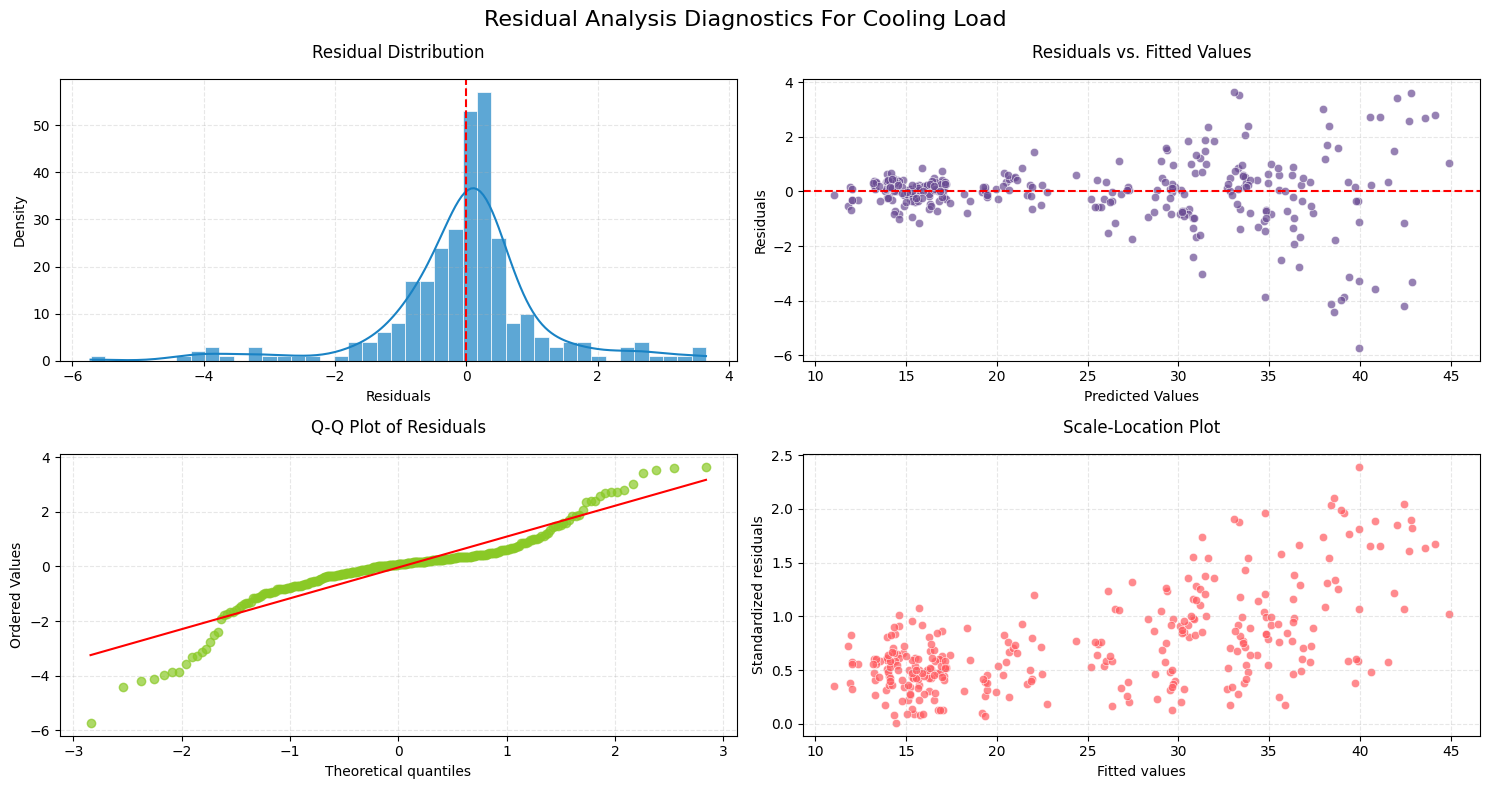

In [8]:
#Cell 8
def residual_analysis(model, X, y):
    y_pred = model.predict(X)
    residuals = y - y_pred

    X_const = sm.add_constant(X)
    bp_test = het_breuschpagan(residuals, X_const)
    white_test = het_white(residuals, X_const)
    
    print("\nResidual Diagnostics")

    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test: p-value={shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print(f"Shapiro-Wilk: Residuals likely normal (p > {0.05}).")
    else:
        print(f"Shapiro-Wilk: Residuals deviate from normality (p ≤ {0.05}).")

    
    bp_pvalue = bp_test[1]
    print(f"Breusch-Pagan Test: p-value={bp_pvalue:.4f}")
    if bp_pvalue < 0.05:
        print("Evidence of heteroscedasticity")
    else:
        print("No significant evidence of heteroscedasticity")
    
    white_pvalue = white_test[1]
    print(f"White Test: p-value={white_pvalue:.4f}")
    if white_pvalue < 0.05:
        print("Evidence of heteroscedasticity")
    else:
        print("No significant evidence of heteroscedasticity")
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 8))
    fig.suptitle('Residual Analysis Diagnostics For Cooling Load', fontsize=16, y=0.98)
    
    colors = ['#6A4C93', '#1982C4', '#8AC926', '#FF595E']

    sns.histplot(residuals, kde=True, ax=ax[0, 0], 
                color=colors[1], alpha=0.7, edgecolor='white', linewidth=0.5)
    ax[0, 0].axvline(x=0, color='r', linestyle='--', linewidth=1.5)
    ax[0, 0].set_title('Residual Distribution', pad=15)
    ax[0, 0].set_xlabel('Residuals')
    ax[0, 0].set_ylabel('Density')
    ax[0, 0].grid(True, linestyle='--', alpha=0.3)

    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, ax=ax[0, 1], 
                   color=colors[0], edgecolor='white', linewidth=0.5)
    ax[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    ax[0, 1].set_title('Residuals vs. Fitted Values', pad=15)
    ax[0, 1].set_xlabel('Predicted Values')
    ax[0, 1].set_ylabel('Residuals')
    ax[0, 1].grid(True, linestyle='--', alpha=0.3)
    
    stats.probplot(residuals, dist="norm", plot=ax[1, 0])
    ax[1, 0].get_lines()[0].set_markerfacecolor(colors[2])
    ax[1, 0].get_lines()[0].set_markeredgecolor(colors[2])
    ax[1, 0].get_lines()[0].set_alpha(0.7)
    ax[1, 0].get_lines()[1].set_color('red')
    ax[1, 0].set_title('Q-Q Plot of Residuals', pad=15)
    ax[1, 0].grid(True, linestyle='--', alpha=0.3)
    
    sns.scatterplot(x=y_pred, y=np.sqrt(np.abs(residuals)), alpha=0.7, ax=ax[1, 1],
                   color=colors[3], edgecolor='white', linewidth=0.5)
    ax[1, 1].set_title('Scale-Location Plot', pad=15)
    ax[1, 1].set_xlabel('Fitted values')
    ax[1, 1].set_ylabel('Standardized residuals')
    ax[1, 1].grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return bp_test, white_test, residuals

print("\nTest Set Diagnostics")
bp_test, white_test, test_residuals = residual_analysis(median_model, X_test, y_test)

# Evaluate percentile range (Cell 9 & 10)

In [9]:
# Cell 9
def evaluate_percentile_range(y_true, lower, upper, y_pred, tolerance=0.5):
    strict_coverage = (y_true >= lower) & (y_true <= upper)
    
    relaxed_coverage = strict_coverage | (np.abs(y_true - y_pred) <= tolerance)
    
    coverage = np.mean(relaxed_coverage)
    width = np.mean(upper - lower)
    
    print("Model-Estimated 5th-95th Percentile Range (with tolerance)")
    print(f"Coverage: {coverage:.2%} of actual values fall within range")
    print(f"Average Width: {width:.2f}")
    
    return coverage, width, relaxed_coverage

quant_coverage, quant_width, relaxed_flags = evaluate_percentile_range(
    y_test, y_lower_quant, y_upper_quant, y_pred_test, tolerance=0.5)

results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_test,
    'Residual': y_test - y_pred_test,
    '5th Percentile': y_lower_quant,
    '95th Percentile': y_upper_quant,
    'Within Range': relaxed_flags,
    'Absolute Error': np.abs(y_test - y_pred_test),
    'Std Residual': (y_test - y_pred_test) / np.std(test_residuals)
})

print("\nSample Predictions with Diagnostic Flags")
print(results.head(10).round(2).to_string(index=False))





Model-Estimated 5th-95th Percentile Range (with tolerance)
Coverage: 78.90% of actual values fall within range
Average Width: 2.42

Sample Predictions with Diagnostic Flags
 Actual  Predicted  Residual  5th Percentile  95th Percentile  Within Range  Absolute Error  Std Residual
  16.90      16.68      0.22           16.53            16.71          True            0.22          0.18
  16.39      16.16      0.23           15.66            16.22          True            0.23          0.19
  32.78      32.67      0.11           32.88            33.01          True            0.11          0.09
  46.23      43.56      2.67           35.88            47.41          True            2.67          2.23
  19.76      20.05     -0.29           19.50            20.33          True            0.29         -0.24
  24.61      26.14     -1.53           25.56            28.69         False            1.53         -1.27
  25.63      25.91     -0.28           25.69            27.80          True          

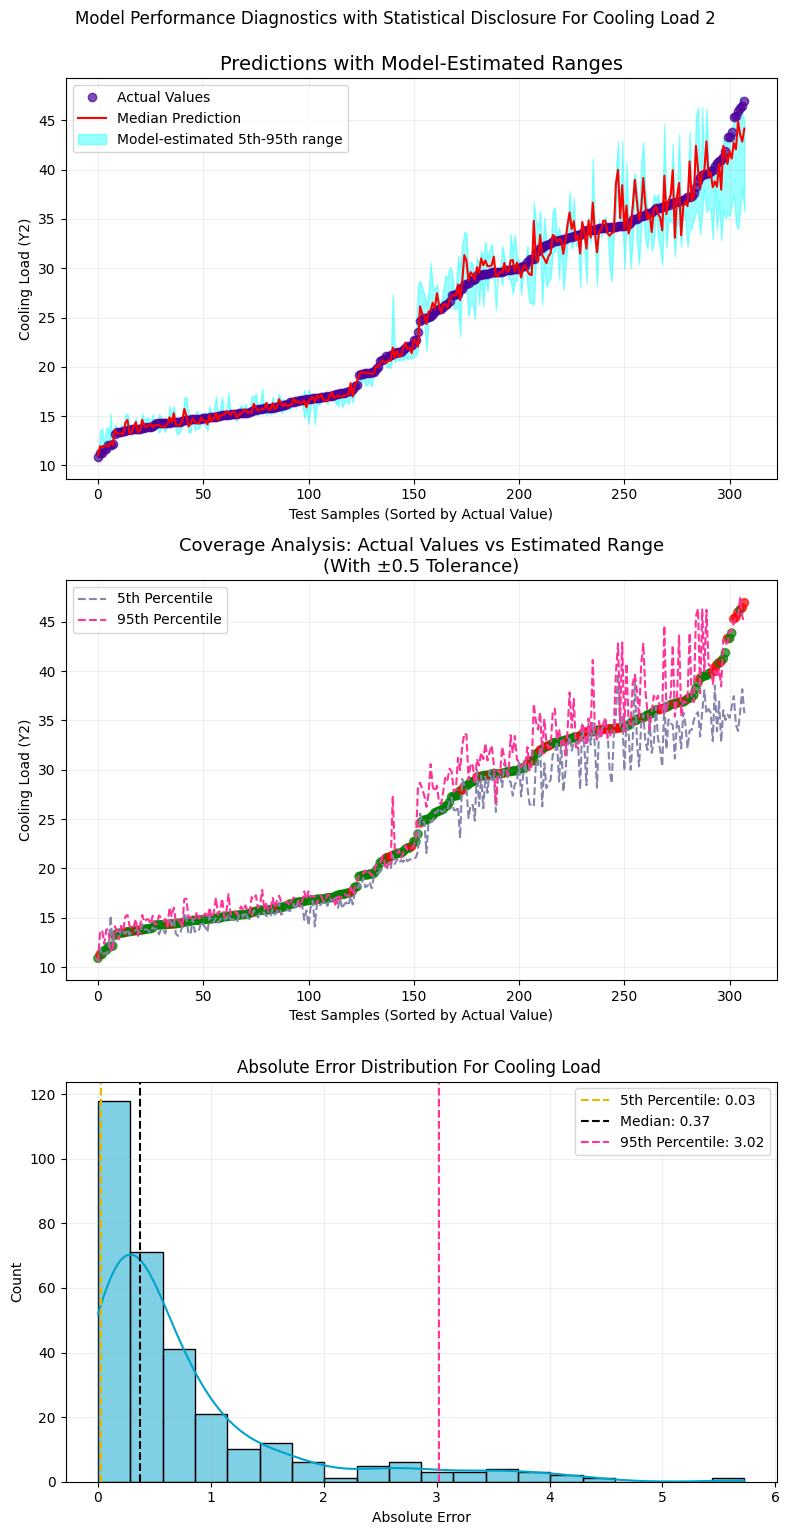

In [10]:
# Cell 10

plt.figure(figsize=(8, 15))

plt.subplot(311)
sorted_idx = np.argsort(y_test.values)
plt.plot(y_test.values[sorted_idx], 'o', color='#4d0099', label="Actual Values", alpha=0.7)
plt.plot(y_pred_test[sorted_idx], '-', color='#ff0000', label="Median Prediction", linewidth=1.5)

plt.fill_between(
    range(len(y_test)), 
    y_lower_quant[sorted_idx], 
    y_upper_quant[sorted_idx], 
    color='#00ffff', alpha=0.4, label="Model-estimated 5th-95th range"
)

plt.title("Predictions with Model-Estimated Ranges", fontsize=14)
plt.xlabel("Test Samples (Sorted by Actual Value)")
plt.ylabel("Cooling Load (Y2)")
plt.legend()
plt.grid(alpha=0.2)

plt.subplot(312)

results_sorted = results.iloc[sorted_idx].reset_index(drop=True)

colors = ['green' if x else 'red' for x in results_sorted['Within Range']]
plt.scatter(range(len(y_test)), results_sorted['Actual'], c=colors, alpha=0.7)

plt.plot(results_sorted['5th Percentile'], '--', color='#8585ad', alpha=1, label='5th Percentile')
plt.plot(results_sorted['95th Percentile'], '--', color='#ff3399', alpha=1, label='95th Percentile')

plt.title("Coverage Analysis: Actual Values vs Estimated Range\n(With ±0.5 Tolerance)", fontsize=13)
plt.xlabel("Test Samples (Sorted by Actual Value)")
plt.ylabel("Cooling Load (Y2)")
plt.legend()
plt.grid(alpha=0.2)

plt.subplot(313)
abs_errors = results['Absolute Error'].values
sns.histplot(abs_errors, kde=True, bins=20, color='#00a3cc', alpha=0.5)

# Error thresholds
q5, q50, q95 = np.percentile(abs_errors, [5, 50, 95])
plt.axvline(x=q5, color='#e6b800', linestyle='--', label=f'5th Percentile: {q5:.2f}')
plt.axvline(x=q50, color='black', linestyle='--', label=f'Median: {q50:.2f}')
plt.axvline(x=q95, color='#ff3399', linestyle='--', label=f'95th Percentile: {q95:.2f}')

plt.title("Absolute Error Distribution For Cooling Load ")
plt.xlabel("Absolute Error")
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.suptitle("Model Performance Diagnostics with Statistical Disclosure For Cooling Load 2", y=1.02)
plt.show()



# Model Robustness against Noisy Data (Cell 11 & 12)

Model Robustness test with noisy data
Testing model robustness with increasing noise levels...
Testing with 1% noise...
Testing with 3% noise...
Testing with 5% noise...
Testing with 10% noise...
Testing with 15% noise...
Testing with 20% noise...


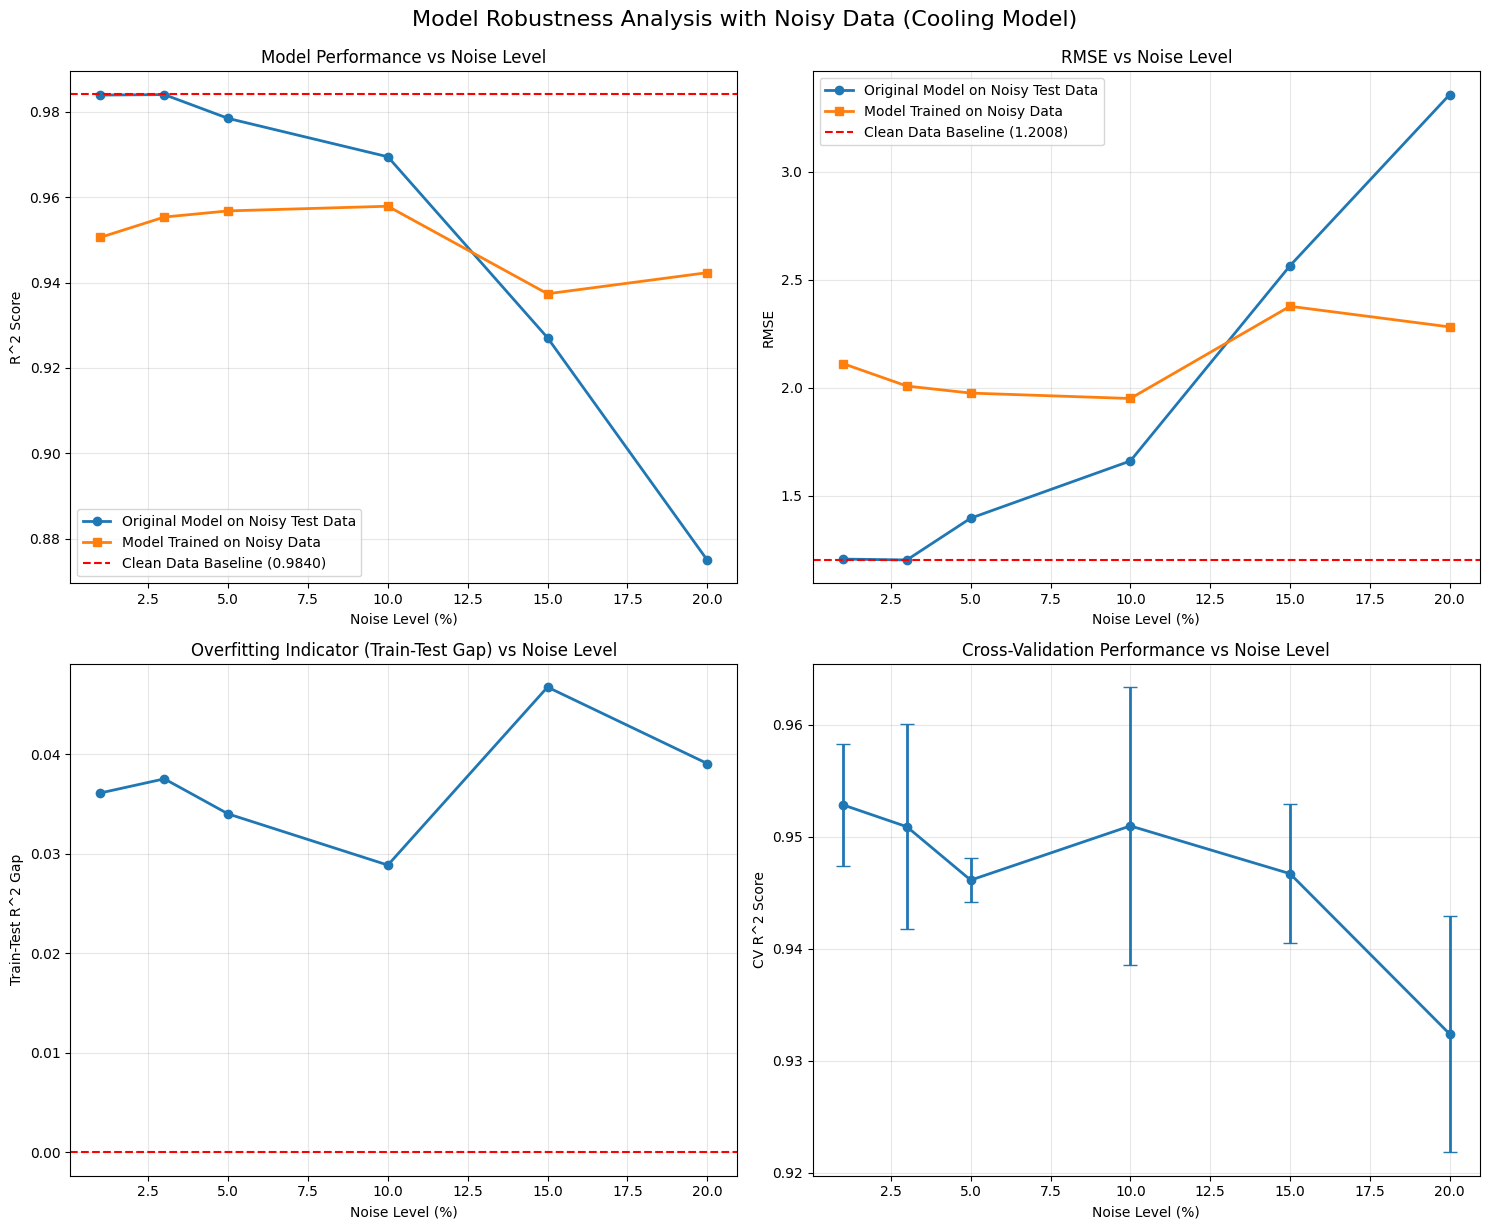


Summary of Results:
 Noise %  Orig Model R^2  Noisy Model R^2  Train-Test Gap  CV Mean R^2
     1.0          0.9839           0.9506          0.0361       0.9528
     3.0          0.9840           0.9553          0.0375       0.9509
     5.0          0.9784           0.9568          0.0340       0.9461
    10.0          0.9694           0.9578          0.0289       0.9510
    15.0          0.9271           0.9374          0.0468       0.9467
    20.0          0.8751           0.9423          0.0391       0.9324


In [11]:
# Cell 11
print("Model Robustness test with noisy data")

def add_noise_to_features(X, noise_level=0.05, features_to_noise=None):

    X_noisy = X.copy()
    
    if features_to_noise is None:
        features_to_noise = ['Relative Compactness', 'Surface Area', 'Wall Area', 
                            'Roof Area', 'Overall Height', 'Glazing Area']
    
    for feature in features_to_noise:
        if feature in X_noisy.columns:
            std_dev = X_noisy[feature].std()
            noise = np.random.normal(0, noise_level * std_dev, len(X_noisy))
            X_noisy[feature] = X_noisy[feature] + noise
    
    return X_noisy

def evaluate_original_model_on_noisy_test(model, X_test, y_test, noise_level, features_to_noise=None):

    X_test_noisy = add_noise_to_features(X_test, noise_level, features_to_noise)
    
    y_pred = model.predict(X_test_noisy)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    return r2, rmse, mae

def train_and_evaluate_on_noisy_data(X, y, model_params, noise_level, test_size=0.4, 
                                    random_state=42, features_to_noise=None):

    X_noisy = add_noise_to_features(X, noise_level, features_to_noise)
    
    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
        X_noisy, y, test_size=test_size, shuffle=True, random_state=random_state
    )
    
    noisy_model = GradientBoostingRegressor(
        loss='quantile',
        alpha=0.5,
        random_state=random_state,
        **model_params
    )
    noisy_model.fit(X_train_n, y_train_n)
    
    train_r2 = r2_score(y_train_n, noisy_model.predict(X_train_n))
    test_r2 = r2_score(y_test_n, noisy_model.predict(X_test_n))
    rmse = np.sqrt(mean_squared_error(y_test_n, noisy_model.predict(X_test_n)))
    mae = mean_absolute_error(y_test_n, noisy_model.predict(X_test_n))
    
    cv_scores = cross_val_score(noisy_model, X_train_n, y_train_n, cv=5, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    return {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': rmse,
        'mae': mae,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'gap': train_r2 - test_r2
    }

features_to_noise = ['Relative Compactness', 'Surface Area', 'Wall Area', 
                    'Roof Area', 'Overall Height', 'Glazing Area']

noise_levels = [0.01, 0.03, 0.05, 0.10, 0.15, 0.20]  # 1% to 20% noise
results = []

print("Testing model robustness with increasing noise levels...")
for noise_level in noise_levels:
    print(f"Testing with {noise_level*100:.0f}% noise...")
    
    noisy_r2, noisy_rmse, noisy_mae = evaluate_original_model_on_noisy_test(
        median_model, X_test, y_test, noise_level, features_to_noise
    )
    
    noisy_model_results = train_and_evaluate_on_noisy_data(
        X, y, best_params, noise_level, test_size=0.4, 
        random_state=random_seed, features_to_noise=features_to_noise
    )
    
    results.append({
        'noise_level': noise_level,
        'noise_pct': noise_level * 100,
        'original_model_r2': noisy_r2,
        'original_model_rmse': noisy_rmse,
        'original_model_mae': noisy_mae,
        'noisy_model_train_r2': noisy_model_results['train_r2'],
        'noisy_model_test_r2': noisy_model_results['test_r2'],
        'noisy_model_rmse': noisy_model_results['rmse'],
        'noisy_model_mae': noisy_model_results['mae'],
        'noisy_model_gap': noisy_model_results['gap'],
        'noisy_model_cv_mean': noisy_model_results['cv_mean'],
        'noisy_model_cv_std': noisy_model_results['cv_std']
    })

results_df = pd.DataFrame(results)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: R² comparison
axes[0, 0].plot(results_df['noise_pct'], results_df['original_model_r2'], 
               'o-', label='Original Model on Noisy Test Data', linewidth=2)
axes[0, 0].plot(results_df['noise_pct'], results_df['noisy_model_test_r2'], 
               's-', label='Model Trained on Noisy Data', linewidth=2)
axes[0, 0].axhline(y=test_metrics['R^2'], color='r', linestyle='--', 
                  label=f'Clean Data Baseline ({test_metrics["R^2"]:.4f})')
axes[0, 0].set_xlabel('Noise Level (%)')
axes[0, 0].set_ylabel('R^2 Score')
axes[0, 0].set_title('Model Performance vs Noise Level')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: RMSE comparison
axes[0, 1].plot(results_df['noise_pct'], results_df['original_model_rmse'], 
               'o-', label='Original Model on Noisy Test Data', linewidth=2)
axes[0, 1].plot(results_df['noise_pct'], results_df['noisy_model_rmse'], 
               's-', label='Model Trained on Noisy Data', linewidth=2)
axes[0, 1].axhline(y=test_metrics['RMSE'], color='r', linestyle='--', 
                  label=f'Clean Data Baseline ({test_metrics["RMSE"]:.4f})')
axes[0, 1].set_xlabel('Noise Level (%)')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE vs Noise Level')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Performance gap
axes[1, 0].plot(results_df['noise_pct'], results_df['noisy_model_gap'], 
               'o-', linewidth=2)
axes[1, 0].set_xlabel('Noise Level (%)')
axes[1, 0].set_ylabel('Train-Test R^2 Gap')
axes[1, 0].set_title('Overfitting Indicator (Train-Test Gap) vs Noise Level')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cross-validation stability
axes[1, 1].errorbar(results_df['noise_pct'], results_df['noisy_model_cv_mean'],
                   yerr=results_df['noisy_model_cv_std'], fmt='o-', 
                   capsize=5, linewidth=2)
axes[1, 1].set_xlabel('Noise Level (%)')
axes[1, 1].set_ylabel('CV R^2 Score')
axes[1, 1].set_title('Cross-Validation Performance vs Noise Level')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Model Robustness Analysis with Noisy Data (Cooling Model)', y=1.02, fontsize=16)
plt.show()

print("\nSummary of Results:")
summary_df = results_df[['noise_pct', 'original_model_r2', 'noisy_model_test_r2', 
                        'noisy_model_gap', 'noisy_model_cv_mean']].copy()
summary_df.columns = ['Noise %', 'Orig Model R^2', 'Noisy Model R^2', 
                     'Train-Test Gap', 'CV Mean R^2']
print(summary_df.round(4).to_string(index=False))

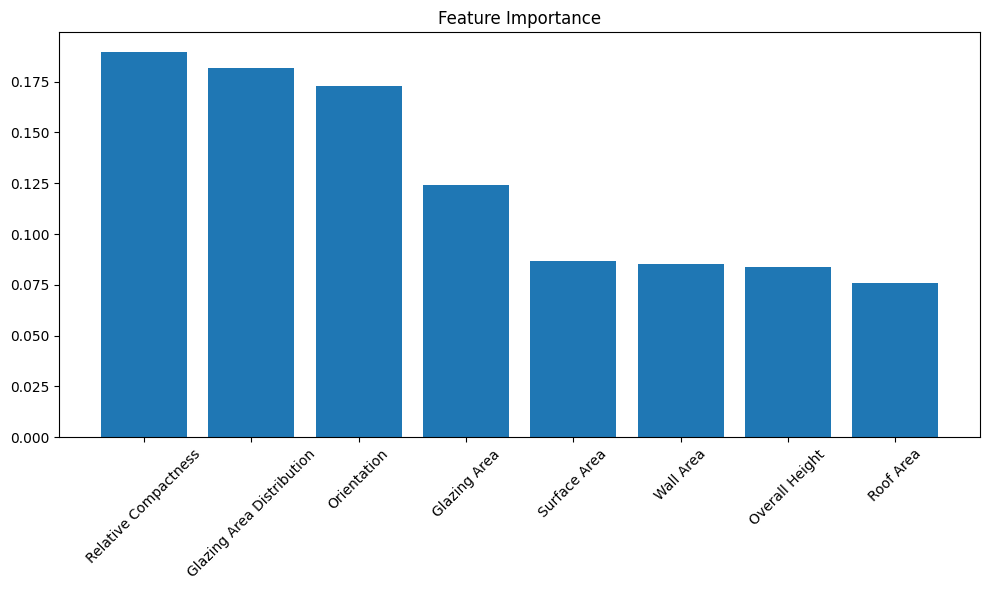

In [12]:
# Cell 12
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(median_model, feature_names)

# Save Models (Cell 13):

In [ ]:
# Cell 13
def save_models():

    models_dir = "saved_models"
    os.makedirs(models_dir, exist_ok=True)
    

    joblib.dump(median_model, os.path.join(models_dir, 'median_model_cooling_load.pkl'))
    joblib.dump(quantile_lower, os.path.join(models_dir, 'quantile_lower_model_cooling_load.pkl'))
    joblib.dump(quantile_upper, os.path.join(models_dir, 'quantile_upper_model_cooling_load.pkl'))
    

    model_metadata = {
        'feature_names': feature_names.tolist(),
        'best_params': best_params
    }
    joblib.dump(model_metadata, os.path.join(models_dir, 'model_metadata_cooling_load.pkl'))
    
    print(f"Models saved successfully in '{models_dir}' directory with specified names!")
    return models_dir
save_models()
